In [192]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import pytz
from pytz import timezone
from tqdm import tqdm
tqdm.pandas()

# Aircube Data - Importing and preprocessing

In [193]:
def preprocess_aircube_df(df):
    
    #convert datetime from utc to cet, only for Aircube data
    df['time'] = pd.to_datetime(df['time']).progress_apply(lambda x : x.replace(tzinfo=timezone('UTC')).astimezone(pytz.timezone('Europe/Berlin'))) #13 secs
    
    #remove rows where the battery level is spiking
    df['battery'] = df[[col for col in df.columns if 'battery' in col]]
    df = df[df['battery'].isna()]
    
    df['aircube_temp'] = df[[col for col in df.columns if 'temperature' in col]]
    df['aircube_humidity'] = df[[col for col in df.columns if 'humidity' in col]]
    
    df.reset_index(drop=True)
    return df

## HAE - Härkingen

Consists of the following 4 sensors:
* AC009, AC011, AC012 - deployed from 2017-04-12 to 2017-07-20
* AC010 - deployed from 2017-05-05 to 2017-07-20

<b> This data is to be used as calibration (training) dataset.  </b> The four sensors were then moved to two other cities:

In [194]:
hae_09 = preprocess_aircube_df(pd.read_csv("Switzerland/AC009_HAE.csv", sep=";"))
hae_10 = preprocess_aircube_df(pd.read_csv("Switzerland/AC010_HAE.csv", sep=";"))
hae_11 = preprocess_aircube_df(pd.read_csv("Switzerland/AC011_HAE.csv", sep=";"))
hae_12 = preprocess_aircube_df(pd.read_csv("Switzerland/AC012_HAE.csv", sep=";"))

100%|███████████████████████████████████████████████████████████████████████| 142020/142020 [00:04<00:00, 34289.15it/s]


## ZUE - Zurich-Kaserne

AC009, AC010 - deployed from 2017-07-28 to 2018-05-17

In [195]:
zue_09 = preprocess_aircube_df(pd.read_csv("Switzerland/AC009_ZUE.csv", sep=";"))
zue_10 = preprocess_aircube_df(pd.read_csv("Switzerland/AC010_ZUE.csv", sep=";"))

100%|███████████████████████████████████████████████████████████████████████| 421620/421620 [00:11<00:00, 36973.01it/s]


## LAU - Lausanne

AC011, AC012 - deployed from 2017-07-27 to 2018-05-17

In [196]:
lau_11 = preprocess_aircube_df(pd.read_csv("Switzerland/AC011_LAU.csv", sep=";"))
lau_12 = preprocess_aircube_df(pd.read_csv("Switzerland/AC012_LAU.csv", sep=";"))

100%|███████████████████████████████████████████████████████████████████████| 422760/422760 [00:10<00:00, 38434.90it/s]


---
---
---

# Reference data

In [6]:
def zue_ref_specific_preprocessing(zue_ref):    

    #the first 3 lines have headers, the last one is empty
    zue_ref = zue_ref.iloc[3:-1]
    
    #reorganise columns
    zue_ref[['time', 'o3_ppb']] = zue_ref['Station:;Zürich [16]'].str.split(';', expand=True).iloc[:, :2]
    zue_ref.drop(['Unnamed: 5', 'Station:;Zürich [16]'], axis=1, inplace=True)
    zue_ref.rename(columns = {'Zürich [16]':'no2_ppb', 'Zürich [16].1':'no_ppb', 'Zürich [16].2':'temp_c', 'Zürich [16].3':'feucht_pc'}, inplace = True)
    return zue_ref

In [7]:
def hae_ref_specific_preprocessing(hae_ref):

    if 'H2O' not in hae_ref.iloc[0, :].tolist():
        
        hae_ref = hae_ref.iloc[3:-1]

        hae_ref[['time', 'no_ppb']] = hae_ref['Station:;Härkingen [6]'].str.split(';', expand=True).iloc[:, :2]
        hae_ref[['o3_ppb', 'flow', 'co2_ppm']] = hae_ref['Härkingen [6].1'].str.split(';', expand=True).iloc[:, :3]
    
        hae_ref.drop(['Unnamed: 7', 'Station:;Härkingen [6]', 'Härkingen [6].1', 'Härkingen [6].5'], inplace=True, axis=1)
        hae_ref.rename(columns = {'Härkingen [6]' : 'no2_ppb', 'Härkingen [6].2' : 'temp_c', 'Härkingen [6].3' : 'feucht_pc', 'Härkingen [6].4' : 'druck_hpa'}, inplace=True)
    
    else:
        hae_ref = hae_ref.iloc[3:-1]

        hae_ref[['time', 'no_ppb']] = hae_ref['Station:;Härkingen [6]'].str.split(';', expand=True).iloc[:, :2]
        hae_ref[['o3_ppb', 'flow', 'co2_ppm']] = hae_ref['Härkingen [6].1'].str.split(';', expand=True).iloc[:, :3]
    
        hae_ref.drop(['Unnamed: 8', 'Station:;Härkingen [6]', 'Härkingen [6].1', 'Härkingen [6].6'], inplace=True, axis=1)
        hae_ref.rename(columns = {'Härkingen [6]' : 'no2_ppb', 'Härkingen [6].2' : 'h2o', 'Härkingen [6].3' : 'temp_c', 'Härkingen [6].4' : 'feucht_pc', 'Härkingen [6].5' : 'druck_hpa'}, inplace=True)
      
    return hae_ref

In [8]:
def lau_ref_specific_preprocessing(lau_ref):
    
    lau_ref = lau_ref[3:-1]

    lau_ref[['time', 'no_ppb']] = lau_ref['Station:;Lausanne [9]'].str.split(';', expand=True).iloc[:, :2]
    
    lau_ref.drop(['Unnamed: 6', 'Station:;Lausanne [9]'], inplace=True, axis=1)
    lau_ref.rename(columns = {'Lausanne [9]' : 'no2_ppb', 'Lausanne [9].1' : 'o3_ppb', 'Lausanne [9].2' : 'temp_c', 'Lausanne [9].3' : 'feucht_pc', 'Lausanne [9].4' : 'druck_hpa'}, inplace=True)

    return lau_ref

In [9]:
def preprocess_nabel_ref_df(ref, city):

    if city == 'HAE':
        ref = hae_ref_specific_preprocessing(ref)
        
    elif city == 'LAU':
        ref = lau_ref_specific_preprocessing(ref)
        
    elif city == 'ZUE':
        ref = zue_ref_specific_preprocessing(ref)
        
    #typecasting time to datetime
    ref['time'] =  pd.to_datetime(ref['time'])#, format='%d%b%Y:%H:%M.%f')
    
    #reordering columns
    #ref = ref.iloc[:, [4, 5,  0, 1, 2, 3]]
    
    ref.reset_index(inplace=True)
    ref.drop(['index'], axis=1, inplace = True)
    
    # one hour of data overlaps between files. see: zue_ref1.loc[(zue_ref1['time'] == '2017-07-27 06:03:00')]
    ref = ref.iloc[:-59]
    
    return ref

---
---

In [10]:
#HAE:spi Some values have Einheit instead of Flow A; these are left as is. Rows with Eis auf Spiegel Wartung are also left as is, since these have empty feucht (and other) values and will be deleted below.
#LAU, ZUE: Eis auf Spiegel Wartung ,Eis auf Spiegel ,Wartung  to be removed
#columns with kalgas not removed because they have empty feucht values and will be deleted below.

def remove_spiegel_geputzt(filename, city):
    new_filepath = filename.replace("NABEL_"+city, "nabel_cleaned_"+city.lower())
    with open(filename) as file:
        data = file.read().replace("Spiegel geputzt ", "").replace("Eis auf Spiegel Wartung ", "").replace("Eis auf Spiegel ", "").replace("Intensity B ", "")#.replace("Wartung ", "")#.replace("Kalgas ", "")
        #print(data)
    with open(new_filepath, 'w+') as file:
        file.write(data)

def clean_spiegel_nabel_ref_data(city):
    import os
    path = 'Switzerland/NABEL_' + city + '/'
    for filename in tqdm(os.listdir(path)):
        a = os.path.join(path, filename)
        #print(a)
        with open(a, 'r') as f:
            remove_spiegel_geputzt(a, city)

In [11]:
clean_spiegel_nabel_ref_data('HAE')
clean_spiegel_nabel_ref_data('LAU')
clean_spiegel_nabel_ref_data('ZUE')

100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:03<00:00, 93.64it/s]


---
---

In [12]:
zue_ref0 = preprocess_nabel_ref_df(pd.read_csv("Switzerland/NABEL_ZUE/ZUE O3 NO2 Temp Feucht MM1_170727.csv", sep=';;', encoding= 'unicode_escape'), 'ZUE')
lau_ref0 = preprocess_nabel_ref_df(pd.read_csv("Switzerland/NABEL_LAU/LAU Gase und Meteo_180419.csv", sep=';;', encoding= 'unicode_escape'), 'LAU')
hae_ref0 = preprocess_nabel_ref_df(pd.read_csv("Switzerland/NABEL_HAE/HAE Gase und Meteo_170412.csv", sep=';;', encoding= 'unicode_escape'), 'HAE')

# empty dataframe
empty_dataframe_zue = zue_ref0[0:0]
empty_dataframe_lau = lau_ref0[0:0]
empty_dataframe_hae = hae_ref0[0:0]

In [13]:
def import_and_preprocess_nabel_ref_data(city, data):
    import os
    path = 'Switzerland/nabel_cleaned_' + city.lower() + '/'
    for filename in tqdm(os.listdir(path)):
        with open(os.path.join(path, filename), 'r') as f:
            
            df = pd.read_csv(f.name, sep=';;', encoding= 'unicode_escape')
            df = preprocess_nabel_ref_df(df, city)
            data = data.append(df, ignore_index=True)
    return data

In [14]:
hae_ref = import_and_preprocess_nabel_ref_data('HAE', empty_dataframe_hae)
zue_ref = import_and_preprocess_nabel_ref_data('ZUE', empty_dataframe_zue)
lau_ref = import_and_preprocess_nabel_ref_data('LAU', empty_dataframe_lau)
#3 mins 14 secs

100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:21<00:00,  3.65it/s]


---
---

In [15]:
def remove_cols_with_low_or_zero_gas(df, a):
    return df.dropna(axis=0, subset=['feucht_pc']) if a == 1 else df.dropna(axis=0, subset=['feucht_pc']).dropna(axis=0, subset=['druck_hpa'])

In [16]:
hae_ref = remove_cols_with_low_or_zero_gas(hae_ref, 2)
lau_ref = remove_cols_with_low_or_zero_gas(lau_ref, 2)
zue_ref = remove_cols_with_low_or_zero_gas(zue_ref, 1)

In [17]:
#hae_ref['time'].nunique() == len(hae_ref) and zue_ref['time'].nunique() == len(zue_ref) and lau_ref['time'].nunique() == len(lau_ref)

In [ ]:
hae_ref.to_csv("Switzerland/hae_ref.csv", index=False)
zue_ref.to_csv("Switzerland/zue_ref.csv", index=False)
lau_ref.to_csv("Switzerland/lau_ref.csv", index=False)

In [197]:
hae_ref = pd.read_csv("Switzerland/hae_ref.csv")
zue_ref = pd.read_csv("Switzerland/zue_ref.csv")
lau_ref = pd.read_csv("Switzerland/lau_ref.csv")

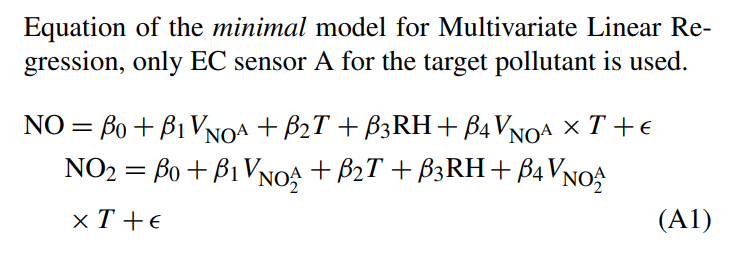

# Feature Extraction

In [198]:
def merge_aircube_with_nabel(aircube_df, nabel_df):
    
    #fixing timezone here because saving it in csv and importing again makes the field's datatype return to object!
    nabel_df['time'] = pd.to_datetime(nabel_df['time']).progress_apply(lambda x : x.replace(tzinfo=timezone('Europe/Berlin')).astimezone(pytz.timezone('Europe/Berlin')))
    
    merged = pd.merge(aircube_df, nabel_df, how='left', on='time')
    
    return merged

In [199]:
hae_09 = merge_aircube_with_nabel(hae_09, hae_ref)
hae_10 = merge_aircube_with_nabel(hae_10, hae_ref)
hae_11 = merge_aircube_with_nabel(hae_11, hae_ref)
hae_12 = merge_aircube_with_nabel(hae_12, hae_ref)

lau_11 = merge_aircube_with_nabel(lau_11, lau_ref)
lau_12 = merge_aircube_with_nabel(lau_12, lau_ref)

zue_09 = merge_aircube_with_nabel(zue_09, zue_ref)
zue_10 = merge_aircube_with_nabel(zue_10, zue_ref)

100%|███████████████████████████████████████████████████████████████████████| 407592/407592 [00:30<00:00, 13490.13it/s]


In [200]:
#lau = concatenate_data_from_two_aircubes_and_merge_with_ref(lau_11, lau_12, lau_ref)
#hae = concatenate_data_from_two_aircubes_and_merge_with_ref(hae_09, hae_10, hae_ref, hae_11, hae_12)
#zue = concatenate_data_from_two_aircubes_and_merge_with_ref(zue_09, zue_10, zue_ref)

In [201]:
#lau_11_full.dtypes

def object_to_float(df):
    df[['o3_ppb', 'temp_c', 'feucht_pc', 'no_ppb', 'no2_ppb']] = df[['o3_ppb', 'temp_c', 'feucht_pc', 'no_ppb', 'no2_ppb']].apply(pd.to_numeric)
    if 'druck_hpa' in df.columns: df[['druck_hpa']] = df[['druck_hpa']].apply(pd.to_numeric)
    return df

In [202]:
def take_working_minus_aux_voltage(full):
    
    full['no2_working_minus_aux_voltage_4'] = full[[col for col in full.columns if col[-10:] == 'no2-we.ch4'][0]] - full[[col for col in full.columns if col[-14:] == 'no2-we-aux.ch4'][0]]
    full['no2_working_minus_aux_voltage_5'] = full[[col for col in full.columns if col[-10:] == 'no2-we.ch5'][0]] - full[[col for col in full.columns if col[-14:] == 'no2-we-aux.ch5'][0]]
    full['no2_working_minus_aux_voltage_mean'] = (full['no2_working_minus_aux_voltage_4'] + full['no2_working_minus_aux_voltage_5'])/2
    
    full['no_working_minus_aux_voltage_6'] = full[[col for col in full.columns if col[-9:] == 'no-we.ch6'][0]] - full[[col for col in full.columns if col[-13:] == 'no-we-aux.ch6'][0]]
    full['no_working_minus_aux_voltage_7'] = full[[col for col in full.columns if col[-9:] == 'no-we.ch7'][0]] - full[[col for col in full.columns if col[-13:] == 'no-we-aux.ch7'][0]]
    full['no_working_minus_aux_voltage_mean'] = (full['no_working_minus_aux_voltage_6'] + full['no_working_minus_aux_voltage_7'])/2
    
    return full

In [203]:
def temp_times_no(df):
    df['temp_times_no_6'] = df[[col for col in df.columns if 'temperature' in col]]
    df['temp_times_no_6'] *= df['no_working_minus_aux_voltage_6']
    
    df['temp_times_no_7'] = df[[col for col in df.columns if 'temperature' in col]]
    df['temp_times_no_7'] *= df['no_working_minus_aux_voltage_7']
    
    df['temp_times_no_mean'] = df['no_working_minus_aux_voltage_6'] * df['no_working_minus_aux_voltage_7']
    
    return df

def temp_times_no2(df):
    df['temp_times_no2_4'] = df[[col for col in df.columns if 'temperature' in col]]
    df['temp_times_no2_4'] *= df['no2_working_minus_aux_voltage_4']
    
    df['temp_times_no2_5'] = df[[col for col in df.columns if 'temperature' in col]]
    df['temp_times_no2_5'] *= df['no2_working_minus_aux_voltage_5']
    
    df['temp_times_no2_mean'] = df['no2_working_minus_aux_voltage_4'] * df['no2_working_minus_aux_voltage_5']
    
    return df

In [204]:
def choose_features(df):
    
    df2 = df[['time', 'aircube_temp',
        'aircube_humidity', 'no2_ppb', 'temp_c',
        'feucht_pc',
        'no_ppb', 'o3_ppb',
        'no2_working_minus_aux_voltage_mean',
        'no_working_minus_aux_voltage_mean',
        'temp_times_no_mean',
        'temp_times_no2_mean']]
    
    if 'flow' in df.columns: df2['flow'] = df['flow']
    if 'druck_hpa' in df.columns: df2['druck_hpa'] = df['druck_hpa']
    if 'co2_ppm' in df.columns: df2['co2_ppm'] = df['co2_ppm']
    if 'h2o' in df.columns: df2['h2o'] = df['h2o']
        
    return df2

In [205]:
def prepare_features(df):
    df = object_to_float(df)
    df = take_working_minus_aux_voltage(df)
    df = temp_times_no(df)
    df = temp_times_no2(df)
    df = choose_features(df)
    return df

In [206]:
hae_09.columns

Index(['time', 'Aircube-009-0.battery', 'Aircube-009-0.no-we-aux.ch6',
       'Aircube-009-0.no-we-aux.ch7', 'Aircube-009-0.no-we.ch6',
       'Aircube-009-0.no-we.ch7', 'Aircube-009-0.no2-we-aux.ch4',
       'Aircube-009-0.no2-we-aux.ch5', 'Aircube-009-0.no2-we.ch4',
       'Aircube-009-0.no2-we.ch5', 'Aircube-009-0.sht-humidity.ch1',
       'Aircube-009-0.sht-temperature.ch1', 'battery', 'aircube_temp',
       'aircube_humidity', 'no2_ppb', 'temp_c', 'feucht_pc', 'druck_hpa',
       'no_ppb', 'o3_ppb', 'flow', 'co2_ppm', 'h2o'],
      dtype='object')

In [207]:
hae_09 = prepare_features(hae_09)
hae_10 = prepare_features(hae_10)
hae_11 = prepare_features(hae_11)
hae_12 = prepare_features(hae_12)

lau_11 = prepare_features(lau_11)
lau_12 = prepare_features(lau_12)

zue_09 = prepare_features(zue_09)
zue_10 = prepare_features(zue_10)

In [208]:
hae_09.columns

Index(['time', 'aircube_temp', 'aircube_humidity', 'no2_ppb', 'temp_c',
       'feucht_pc', 'no_ppb', 'o3_ppb', 'no2_working_minus_aux_voltage_mean',
       'no_working_minus_aux_voltage_mean', 'temp_times_no_mean',
       'temp_times_no2_mean', 'flow', 'druck_hpa', 'co2_ppm', 'h2o'],
      dtype='object')

In [211]:
def concatenate_datasets(df1, df2, df3=None, df4=None):

    if df3 is not None and df4 is not None: df = pd.concat([df1, df2, df3, df4])
    else: df = pd.concat([df1, df2])
        
    df = df.sort_values(by='time')

    df = df.reset_index(drop=True)
    
    return df

In [212]:
hae = concatenate_datasets(hae_09, hae_10, hae_11, hae_12)
lau = concatenate_datasets(lau_11, lau_12)
zue = concatenate_datasets(zue_09, zue_10)

In [213]:
def df_to_predict_no(df):
    return df[['time', 'no_ppb',
                                'no_working_minus_aux_voltage_mean',
                                'aircube_temp',
                                'aircube_humidity',
                                'temp_times_no_mean']]
   
def df_to_predict_no2(df):
    return df[['time', 'no2_ppb',
                                'no2_working_minus_aux_voltage_mean',
                                'aircube_temp',
                                'aircube_humidity',
                                'temp_times_no2_mean']]
                                

In [214]:
hae_to_pred_no = df_to_predict_no(hae)
lau_to_pred_no = df_to_predict_no(lau)
zue_to_pred_no = df_to_predict_no(zue)

hae_to_pred_no2 = df_to_predict_no2(hae)
lau_to_pred_no2 = df_to_predict_no2(lau)
zue_to_pred_no2 = df_to_predict_no2(zue)

In [222]:
def delete_nulls(df): 
    return df.dropna().reset_index(drop=True)

In [223]:
hae_to_pred_no = delete_nulls(hae_to_pred_no)
lau_to_pred_no = delete_nulls(lau_to_pred_no)
zue_to_pred_no = delete_nulls(zue_to_pred_no)

hae_to_pred_no2 = delete_nulls(hae_to_pred_no2)
lau_to_pred_no2 = delete_nulls(lau_to_pred_no2)
zue_to_pred_no2 = delete_nulls(zue_to_pred_no2)

In [225]:
hae_to_pred_no['no_ppb'].min()

-2.7

In [227]:
hae_to_pred_no.to_csv('Switzerland/hae_to_pred_no.csv', index=False)
lau_to_pred_no.to_csv('Switzerland/lau_to_pred_no.csv', index=False)
zue_to_pred_no.to_csv('Switzerland/zue_to_pred_no.csv', index=False)

hae_to_pred_no2.to_csv('Switzerland/hae_to_pred_no2.csv', index=False)
lau_to_pred_no2.to_csv('Switzerland/lau_to_pred_no2.csv', index=False)
zue_to_pred_no2.to_csv('Switzerland/zue_to_pred_no2.csv', index=False)

# Visualisation

In [339]:
import plotly.express as px
def plot_all(df):
    fig = px.line(df, x="time", y=df.columns.tolist(), template = 'plotly_dark')
    fig.show()

# Simple Linear Regression